# Sign Game Server

Game Plan:

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import string

2023-03-14 16:40:09.338941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:40:10.173754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 16:40:10.173781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 16:40:10.263247: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-14 16:40:12.431818: W tensorflow/stream_executor/platform/de

In [2]:
from sign_game.ml.evaluate import evaluate_model
from sign_game.ml.landmarks_utils import normalize_handmarks_per_image 

In [3]:
!pip list | grep sign_game

protobuf 3.11.0

## Dataset Preprocessing

In [4]:
# Dataset
df1 = pd.read_csv('../raw_data/csv_data/train.csv')
df2 = pd.read_csv('../raw_data/csv_data/test.csv')
df_real = pd.read_csv('../raw_data/self_test.csv')

In [5]:
df1 = normalize_handmarks_per_image(df1) 
df2 = normalize_handmarks_per_image(df2) 
df_real = normalize_handmarks_per_image(df_real)

In [6]:
df = df1.copy().dropna().reset_index()
test_df = df2.copy().dropna().reset_index()
df_rw = df_real.copy().dropna().reset_index()

In [7]:
df.columns

Index(['index', 'Unnamed: 0', 'WRIST_X', 'WRIST_Y', 'WRIST_Z', 'THUMB_CMC_X',
       'THUMB_CMC_Y', 'THUMB_CMC_Z', 'THUMB_MCP_X', 'THUMB_MCP_Y',
       'THUMB_MCP_Z', 'THUMB_IP_X', 'THUMB_IP_Y', 'THUMB_IP_Z', 'THUMB_TIP_X',
       'THUMB_TIP_Y', 'THUMB_TIP_Z', 'INDEX_FINGER_MCP_X',
       'INDEX_FINGER_MCP_Y', 'INDEX_FINGER_MCP_Z', 'INDEX_FINGER_PIP_X',
       'INDEX_FINGER_PIP_Y', 'INDEX_FINGER_PIP_Z', 'INDEX_FINGER_DIP_X',
       'INDEX_FINGER_DIP_Y', 'INDEX_FINGER_DIP_Z', 'INDEX_FINGER_TIP_X',
       'INDEX_FINGER_TIP_Y', 'INDEX_FINGER_TIP_Z', 'MIDDLE_FINGER_MCP_X',
       'MIDDLE_FINGER_MCP_Y', 'MIDDLE_FINGER_MCP_Z', 'MIDDLE_FINGER_PIP_X',
       'MIDDLE_FINGER_PIP_Y', 'MIDDLE_FINGER_PIP_Z', 'MIDDLE_FINGER_DIP_X',
       'MIDDLE_FINGER_DIP_Y', 'MIDDLE_FINGER_DIP_Z', 'MIDDLE_FINGER_TIP_X',
       'MIDDLE_FINGER_TIP_Y', 'MIDDLE_FINGER_TIP_Z', 'RING_FINGER_MCP_X',
       'RING_FINGER_MCP_Y', 'RING_FINGER_MCP_Z', 'RING_FINGER_PIP_X',
       'RING_FINGER_PIP_Y', 'RING_FINGER_PIP_Z', 'RI

In [8]:
X_test = test_df.drop(columns=['index', 'Unnamed: 0', 'PATH', 'TARGET'])
X_train = df.drop(columns=['index', 'Unnamed: 0', 'PATH', 'TARGET'])
X_real = df_rw.drop(columns=['index', 'Unnamed: 0', 'TARGET'])
display(X_test)
display(X_train)
display(X_real)

,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
0,0.385186,2.801575,1.882829,-0.751281,2.171180,0.556605,-1.671987,0.741385,-0.001712,-1.095631,...,0.276157,1.620127,-0.587439,-0.718412,1.363665,0.275684,-0.102359,1.284243,0.437009,0.594393
1,-0.529195,2.882589,1.980395,-1.591449,2.053460,0.622020,-1.988227,0.772498,0.016934,-1.048023,...,0.487825,1.548304,-0.562727,0.100223,1.460155,-0.458030,-0.024717,1.256206,-0.093634,-0.006031
2,-1.974264,2.387782,0.283919,-0.865484,1.895311,0.782621,0.058128,1.375598,0.628894,0.908451,...,-1.002453,-0.722410,-0.457209,-1.196080,-0.121388,-0.726194,-1.250116,0.423888,-0.882294,-1.283663
3,-0.048151,2.079766,-1.748567,1.107623,1.543114,-1.950030,1.447938,0.858132,-1.630203,0.632256,...,0.165067,-1.665231,0.189943,0.310140,-1.347223,0.709791,1.016574,-1.075852,1.007363,1.627645
4,0.616188,1.504579,2.531432,-0.059789,1.336091,1.223051,-0.859199,1.018260,0.173816,-1.605012,...,0.590740,1.430987,-0.254600,-0.315075,1.282074,0.302666,0.182305,0.984723,0.443271,0.779126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43295,1.061066,0.831383,2.510490,1.302601,0.287974,1.197491,1.403105,-0.313466,0.204638,1.232563,...,1.085446,-0.317100,1.252225,-0.067312,0.355212,1.178072,-0.148286,0.728359,1.011093,0.093383
43296,-1.748942,0.996553,2.156101,-1.691142,-0.161315,1.278577,-1.106035,-1.175345,0.828648,-0.387812,...,0.460497,0.427096,1.449490,-0.812675,-0.167529,1.268221,-0.564506,-0.627585,1.109405,-0.020285
43297,-2.052956,2.027840,0.790639,-1.740511,0.551800,0.471653,-1.052008,-0.466290,0.514142,-0.402144,...,-0.291703,0.688174,0.956647,-1.291090,0.083273,0.815614,-0.934715,-0.419391,0.879127,-0.268416
43298,0.533199,1.698503,2.804422,-0.455226,1.404728,1.459223,-1.150645,0.883024,0.543778,-0.579353,...,0.312806,1.165465,0.336787,-0.712601,0.536152,0.638695,-0.606545,0.306374,0.860937,-0.247325


,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
0,1.142823,2.420187,1.735661,-0.338310,1.912172,0.524164,-0.984027,1.122712,0.176097,-0.219408,...,-0.009308,1.482592,-0.035783,-0.560045,1.307420,-0.439379,-0.938440,1.134088,-0.780904,-1.319878
1,-0.206491,0.405551,2.662816,0.642962,0.613478,1.909166,1.234313,0.488954,1.183384,1.285006,...,0.482572,-1.509404,-0.496083,-0.153672,-1.417121,0.403382,-0.449521,-1.239794,1.088117,-0.676929
2,1.973671,2.129013,1.686453,0.941413,1.879122,1.377149,0.002520,1.439787,0.916804,-0.854252,...,-0.124902,0.987267,-0.433660,-0.842227,0.364119,-0.684233,-1.247715,-0.203164,-0.724466,-1.482050
3,0.633569,2.440658,1.952173,-0.222620,2.144059,0.207797,-1.145840,1.258114,-0.696534,-1.832201,...,0.623584,1.271229,-0.759980,-0.446125,1.130678,-0.017559,0.191993,1.117493,0.239376,0.973327
4,0.288975,1.889581,2.051425,-0.330760,1.712542,0.713202,-1.122957,1.413860,-0.294774,-2.028529,...,1.105115,1.198654,-0.048417,0.780266,0.947835,-0.425212,0.628332,0.572357,-0.666319,0.526154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172624,-2.424385,1.942646,2.252828,-1.262070,1.769918,1.289735,-0.225938,1.441550,0.604598,0.676020,...,0.686034,-0.361986,-0.100667,-0.005276,0.258269,-0.386949,-0.450608,0.810567,-0.572144,-0.753644
172625,-0.070228,2.757199,1.983487,-0.836203,1.681637,0.724740,-1.381807,0.573358,-0.002208,-1.747205,...,1.077087,1.286252,-0.509846,-0.203457,1.568185,-0.976600,-0.342090,1.794751,-1.532300,-0.142066
172626,0.460274,2.872303,1.845231,-0.906331,2.136306,0.606434,-1.349189,0.908223,-0.092842,-0.577868,...,0.399985,1.581284,-0.601321,0.175610,1.208951,-0.234102,0.702588,1.026617,0.302288,1.024608
172627,1.395267,2.188025,1.324044,0.231435,1.817687,1.227704,-0.524672,1.347492,0.814041,-1.122341,...,-0.588866,1.365769,-0.398576,-0.958703,1.078800,-0.878881,-1.153086,0.725720,-1.291724,-1.243922


,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
0,-0.559807,2.642815,1.522140,0.715323,1.521785,0.739287,1.607965,0.382529,0.285706,1.780164,...,0.548318,-1.368759,-0.585154,-0.689555,-0.950396,0.209581,-0.378566,-0.866727,0.921973,0.278087
1,-0.794405,2.400942,1.573076,0.499092,1.724756,0.594225,1.499339,0.537651,0.289327,1.773301,...,0.862071,-1.298747,-0.680548,-0.798959,-1.019695,0.244305,-0.582044,-0.934800,1.034087,0.145491
2,-0.768912,2.392085,1.541429,0.509775,1.709015,0.545461,1.474620,0.534278,0.218394,1.765640,...,0.862651,-1.304285,-0.674263,-0.783973,-1.009866,0.249321,-0.526770,-0.912045,1.026409,0.237322
3,-0.793828,2.408061,1.490839,0.499578,1.697678,0.517025,1.497293,0.541710,0.203849,1.789376,...,0.863311,-1.294423,-0.663743,-0.760740,-1.028430,0.266905,-0.511047,-0.939129,1.046768,0.247018
4,-0.789058,2.410545,1.544490,0.510080,1.730263,0.499969,1.506711,0.558178,0.177509,1.792579,...,0.886286,-1.295660,-0.672225,-0.773132,-1.024452,0.251491,-0.519468,-0.942374,1.021441,0.239552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,0.107327,1.901177,2.283266,1.037645,1.361956,1.175306,1.445001,0.556109,0.601750,1.214167,...,0.529075,-1.802529,0.192306,-0.914308,-1.084024,0.606864,-0.534996,-0.691223,0.902122,0.158572
3643,0.115689,1.870391,2.302204,1.027720,1.356391,1.161717,1.443868,0.551233,0.581497,1.189263,...,0.559546,-1.798913,0.189038,-0.863330,-1.089025,0.605114,-0.438125,-0.728084,0.889394,0.293077
3644,0.095751,1.863273,2.325120,1.007594,1.347745,1.185111,1.429164,0.553050,0.586623,1.231163,...,0.564849,-1.807968,0.199361,-0.841436,-1.090060,0.606464,-0.458561,-0.700017,0.892587,0.233447
3645,0.082251,1.865510,2.298180,0.999780,1.342267,1.209839,1.431201,0.538662,0.641245,1.200556,...,0.529829,-1.812604,0.184970,-0.885707,-1.090032,0.604195,-0.482894,-0.703946,0.898390,0.228559


In [9]:
y_test=test_df['TARGET']
y_train=df['TARGET']
y_real=df_rw['TARGET']
display(y_train)
display(y_test)
display(y_real)

0         B
1         M
2         C
3         T
4         C
         ..
172624    Q
172625    Y
172626    E
172627    F
172628    I
Name: TARGET, Length: 172629, dtype: object

0        S
1        E
2        C
3        X
4        L
        ..
43295    Z
43296    G
43297    G
43298    V
43299    C
Name: TARGET, Length: 43300, dtype: object

0       A
1       A
2       A
3       A
4       A
       ..
3642    Z
3643    Z
3644    Z
3645    Z
3646    Z
Name: TARGET, Length: 3647, dtype: object

In [10]:
display(y_train.value_counts())
display(y_test.value_counts())
display(y_real.value_counts())

L    7735
F    7616
D    7488
K    7311
B    7252
E    7213
R    7153
A    7101
I    7080
Z    7006
V    6897
X    6897
W    6863
O    6854
Y    6698
J    6682
S    6674
C    6615
T    6459
G    6396
H    6077
U    5546
M    5434
P    5411
Q    5192
N    4979
Name: TARGET, dtype: int64

F    1911
K    1875
L    1873
D    1860
Z    1829
E    1810
X    1793
B    1774
R    1771
A    1764
I    1740
Y    1735
W    1715
O    1706
V    1701
T    1689
C    1681
J    1665
G    1629
S    1627
H    1530
Q    1390
M    1365
U    1347
P    1300
N    1220
Name: TARGET, dtype: int64

N    145
X    145
V    145
U    145
T    145
S    145
R    145
Y    145
P    145
O    145
M    145
L    145
K    145
J    145
I    145
F    145
E    145
D    145
C    145
B    144
W    144
G    139
H    131
A    126
Z    114
Q     94
Name: TARGET, dtype: int64

In [11]:
# Encoding letters to numerical, A-Z = 0-25
y_train = pd.Categorical(y_train)
y_test = pd.Categorical(y_test)
y_real = pd.Categorical(y_real)

In [12]:
display(y_train.dtype)
display(y_test.dtype)
display(y_real.dtype)


CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                  'Y', 'Z'],
, ordered=False)

CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                  'Y', 'Z'],
, ordered=False)

CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                  'Y', 'Z'],
, ordered=False)

In [13]:
cat_list = list(y_train.categories)
display(cat_list)

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [14]:
y_test = y_test.codes
y_train = y_train.codes
y_real = y_real.codes
display(len(y_train))
display(y_train)
display(len(y_test))
display(y_test)
display(len(y_real))
display(y_real)

172629

array([ 1, 12,  2, ...,  4,  5,  8], dtype=int8)

43300

array([18,  4,  2, ...,  6, 21,  2], dtype=int8)

3647

array([ 0,  0,  0, ..., 25, 25, 25], dtype=int8)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_real.shape, y_real.shape

((172629, 63), (172629,), (43300, 63), (43300,), (3647, 63), (3647,))

In [16]:
classes = len(cat_list)
print(classes)

26


In [17]:
y_train = to_categorical(y_train, num_classes=classes)
display(y_train)
y_test = to_categorical(y_test, num_classes=classes)
display(y_test)
y_real = to_categorical(y_real, num_classes=classes)
display(y_real)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [18]:
X_train = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1)).astype(np.float32)
X_test = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1)).astype(np.float32)
X_real = np.reshape(np.array(X_real), (X_real.shape[0], X_real.shape[1], 1)).astype(np.float32)
print(X_train.shape, X_test.shape, X_real.shape)

(172629, 63, 1) (43300, 63, 1) (3647, 63, 1)


## CNN Model

### Original CNN

In [19]:
# Architecture
# model = models.Sequential()
# model.add(layers.Conv1D(filters=512, kernel_size=7, strides=1, padding='causal', input_shape=X_train.shape[1:3], activation='relu'))
# model.add(layers.Conv1D(filters=512, kernel_size=7, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='causal', activation='relu'))
# model.add(layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(26, activation='softmax')) 
#accuracy: 0.89

### Reduced CNN 1

In [20]:
# model = models.Sequential()
# model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', input_shape=X_train.shape[1:3], activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(26, activation='softmax'))
# accuracy: 0.71

### Reduced CNN 2

In [21]:
# model = models.Sequential()
# model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', input_shape=X_train.shape[1:3], activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(26, activation='softmax'))
# accuracy: 0.81

### Reduced CNN 3

In [22]:
# model = models.Sequential()
# model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', input_shape=X_train.shape[1:3], activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='causal', activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Dropout(0.2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(26, activation='softmax'))
# accuracy: 0.86

### Reduced CNN 4

In [23]:
model = models.Sequential()
model.add(layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', input_shape=X_train.shape[1:3], activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

2023-03-14 16:40:30.360891: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-14 16:40:30.360949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shan): /proc/driver/nvidia/version does not exist
2023-03-14 16:40:30.361738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 63, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 31, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0

In [26]:
es = EarlyStopping(patience=1, restore_best_weights=True)

In [27]:
%%time
history = model.fit(X_train, 
                    y_train,
                    epochs=500, 
                    validation_split=0.3, 
                    callbacks=es)

Epoch 1/500
3777/3777 [==============================] - 44s 11ms/step - loss: 0.3804 - accuracy: 0.8934 - val_loss: 0.1867 - val_accuracy: 0.9453
Epoch 2/500
3777/3777 [==============================] - 39s 10ms/step - loss: 0.1866 - accuracy: 0.9444 - val_loss: 0.1480 - val_accuracy: 0.9555
Epoch 3/500
3777/3777 [==============================] - 40s 11ms/step - loss: 0.1549 - accuracy: 0.9531 - val_loss: 0.1393 - val_accuracy: 0.9587
Epoch 4/500
3777/3777 [==============================] - 39s 10ms/step - loss: 0.1375 - accuracy: 0.9575 - val_loss: 0.1288 - val_accuracy: 0.9609
Epoch 5/500
3777/3777 [==============================] - 36s 10ms/step - loss: 0.1248 - accuracy: 0.9612 - val_loss: 0.1274 - val_accuracy: 0.9617
Epoch 6/500
3777/3777 [==============================] - 35s 9ms/step - loss: 0.1141 - accuracy: 0.9633 - val_loss: 0.1160 - val_accuracy: 0.9655
Epoch 7/500
3777/3777 [==============================] - 38s 10ms/step - loss: 0.1069 - accuracy: 0.9658 - val_loss: 0.

In [28]:
%%time
y_pred = model.predict(X_test)
display(y_pred)

1354/1354 [==============================] - 7s 5ms/step


array([[3.8463818e-06, 2.5569208e-10, 2.1036989e-10, ..., 1.5663645e-04,
        1.1290930e-11, 2.6383038e-09],
       [1.9394413e-07, 5.3894849e-09, 1.4537760e-09, ..., 9.7564089e-07,
        3.2328571e-09, 1.1959673e-08],
       [1.0278692e-08, 9.6296135e-06, 9.9257314e-01, ..., 5.3997874e-06,
        8.5630064e-10, 1.7173379e-06],
       ...,
       [2.0445522e-12, 6.0962937e-13, 3.8258134e-13, ..., 9.8557315e-08,
        3.4683107e-11, 1.6909584e-05],
       [2.4568365e-21, 3.2172310e-12, 8.3719508e-15, ..., 2.0667310e-09,
        9.0604694e-13, 1.0706895e-09],
       [6.8888612e-13, 3.6055770e-08, 9.9999607e-01, ..., 6.4264521e-10,
        4.1033128e-11, 8.4290762e-11]], dtype=float32)

CPU times: user 8.51 s, sys: 443 ms, total: 8.96 s
Wall time: 60 s


In [29]:
%%time
y_real_pred = model.predict(X_real)
display(y_real_pred)

114/114 [==============================] - 1s 5ms/step


array([[9.9984527e-01, 7.4586318e-12, 1.4327112e-09, ..., 1.3378673e-05,
        1.8930628e-05, 3.0111374e-05],
       [9.9989074e-01, 1.5187566e-11, 9.3579353e-11, ..., 2.5373936e-06,
        1.2892124e-06, 2.0123101e-05],
       [9.9990481e-01, 8.6110919e-12, 5.5908996e-11, ..., 1.7351899e-06,
        9.2064499e-07, 1.7353019e-05],
       ...,
       [3.6937677e-06, 1.1144672e-09, 4.2161847e-07, ..., 6.0757262e-01,
        6.9523566e-08, 1.2827943e-03],
       [4.6818986e-06, 7.5084700e-10, 2.7878656e-07, ..., 5.3401315e-01,
        5.4418546e-08, 1.2258388e-03],
       [3.3287827e-06, 1.1313591e-09, 4.2030484e-07, ..., 6.1453277e-01,
        7.1134941e-08, 1.2175184e-03]], dtype=float32)

CPU times: user 831 ms, sys: 34.8 ms, total: 866 ms
Wall time: 837 ms


In [30]:
y_pred = np.array([[round(b) for b in a] for a in y_pred]) 
y_real_pred = np.array([[round(b) for b in a] for a in y_real_pred]) 
display(y_pred)
display(y_test)
display(y_real, y_real_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [31]:
y_pred = np.argmax(y_pred, axis=1)
y_real_pred = np.argmax(y_real_pred, axis=1)
display(y_pred, y_real_pred)


array([18,  4,  2, ...,  6, 21,  2])

array([ 0,  0,  0, ..., 23, 23, 23])

In [32]:
y_test= np.argmax(y_test, axis=1)
y_real= np.argmax(y_real, axis=1)

display(y_test, y_real)


array([18,  4,  2, ...,  6, 21,  2])

array([ 0,  0,  0, ..., 25, 25, 25])

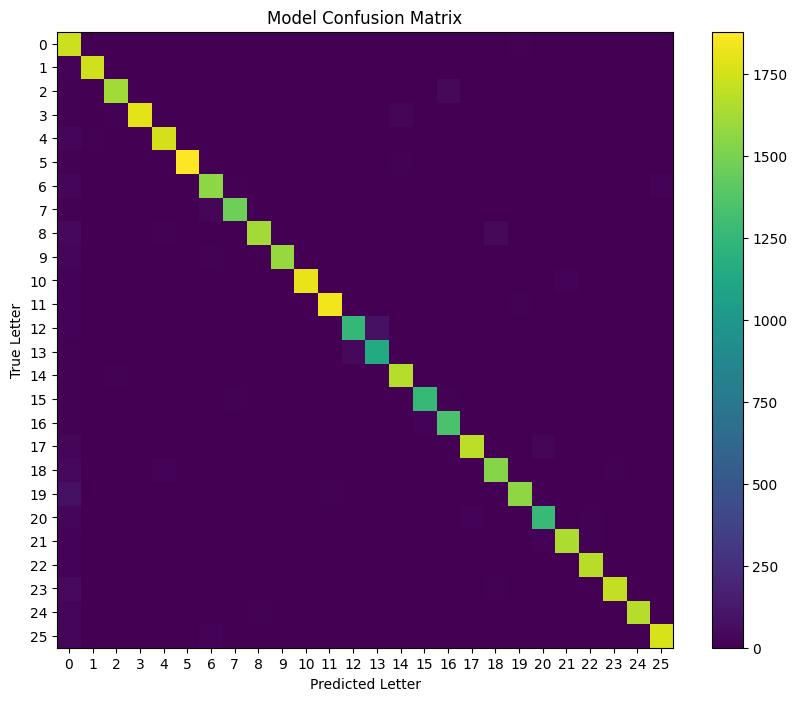

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1764
           1       0.98      0.98      0.98      1774
           2       0.97      0.96      0.97      1681
           3       1.00      0.97      0.98      1860
           4       0.96      0.97      0.97      1810
           5       0.99      0.98      0.99      1911
           6       0.95      0.96      0.96      1629
           7       0.97      0.96      0.97      1530
           8       0.99      0.93      0.96      1740
           9       0.99      0.95      0.97      1665
          10       1.00      0.97      0.98      1875
          11       0.99      0.98      0.99      1873
          12       0.95      0.92      0.93      1365
          13       0.93      0.94      0.94      1220
          14       0.97      0.98      0.97      1706
          15       0.97      0.97      0.97      1300
          16       0.95      0.96      0.96      1390
          17       0.98    

In [33]:
evaluate_model(y_test, y_pred)

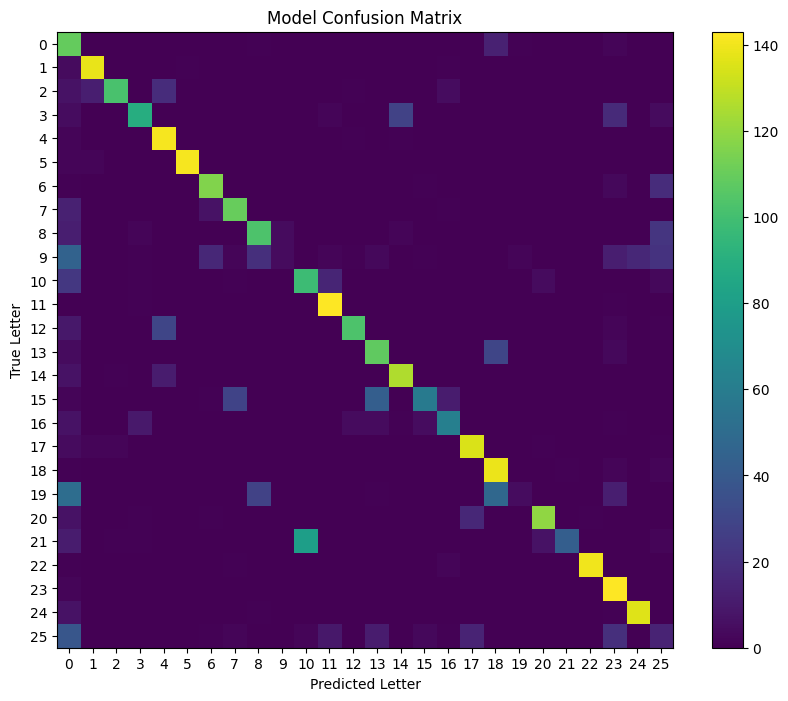

              precision    recall  f1-score   support

           0       0.29      0.87      0.44       126
           1       0.90      0.96      0.93       144
           2       0.96      0.70      0.81       145
           3       0.84      0.61      0.71       145
           4       0.70      0.97      0.82       145
           5       0.99      0.97      0.98       145
           6       0.82      0.83      0.83       139
           7       0.76      0.84      0.80       131
           8       0.68      0.71      0.69       145
           9       0.50      0.03      0.05       145
          10       0.54      0.68      0.60       145
          11       0.84      0.99      0.91       145
          12       0.94      0.71      0.81       145
          13       0.64      0.74      0.69       145
          14       0.80      0.87      0.83       145
          15       0.86      0.41      0.55       145
          16       0.75      0.66      0.70        94
          17       0.82    

In [34]:
evaluate_model(y_real, y_real_pred)
